In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import glob
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import random 
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib.colors import ListedColormap
from torch.cuda.amp import GradScaler, autocast
import math 
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb

In [7]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

True


In [8]:
IDD_CLASSES = {
    0: ('road', (128, 64, 128)),             # Road: Blue-gray
    1: ('drivable', (81, 0, 81)),            # Drivable fallback: Dark purple
    2: ('sidewalk', (244, 35, 232)),         # Sidewalk: Pink
    3: ('non-drivable', (152, 251, 152)),    # Non-drivable: Light green
    4: ('person', (220, 20, 60)),            # Person: Crimson
    5: ('rider', (255, 0, 0)),               # Rider: Red
    6: ('vehicle', (0, 0, 142)),             # Vehicle: Dark blue
    7: ('traffic sign', (220, 220, 0)),      # Traffic sign: Yellow
    8: ('traffic light', (250, 170, 30)),    # Traffic light: Orange
    9: ('pole', (153, 153, 153)),            # Pole: Gray
    10: ('construction', (70, 70, 70)),      # Construction: Dark gray
    11: ('vegetation', (107, 142, 35)),      # Vegetation: Olive green
    12: ('sky', (70, 130, 180)),             # Sky: Steel blue
    13: ('unlabeled', (0, 0, 0))             # Unlabeled: Black
}

IDD_LABEL_MAP = {
    0: 0,    # road
    29: 6,   # car -> vehicle
    30: 6,   # truck -> vehicle
    33: 6,   # bus -> vehicle
    48: 9,   # pole -> pole
    70: 10,  # building -> construction
    76: 11,  # vegetation -> vegetation
    89: 4,   # person -> person
    91: 5,   # rider -> rider
    106: 7,  # traffic sign -> traffic sign
    108: 8,  # traffic light -> traffic light
    124: 2,  # sidewalk -> sidewalk
    130: 3,  # terrain -> non-drivable
    137: 12, # sky -> sky
    140: 6,  # motorcycle -> vehicle
    143: 6,  # bicycle -> vehicle
    150: 10, # wall -> construction
    255: 13  # void/unlabeled -> unlabeled
}


In [9]:
class IDDDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # Using the same mapping we verified
        self.label_map = IDD_LABEL_MAP
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('_leftImg8bit.png')])
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('_leftImg8bit.png', '_gtFine_polygons.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Load files
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Map labels - initialize with unlabeled class (13)
        mapped_mask = np.full_like(mask, 13)
        for raw_label, class_id in self.label_map.items():
            mapped_mask[mask == raw_label] = class_id
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mapped_mask)
            image = augmented['image']
            mapped_mask = augmented['mask']
        
        return image, mapped_mask

    def __len__(self):
        return len(self.images)

In [10]:
def get_transforms(phase):
    if phase == "train":
        return A.Compose([
            A.RandomResizedCrop(height=256, width=256),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=256, width=256),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])


In [11]:
base_path = "/kaggle/input/idd-semantic-segmentation/idd20kII"

# Create datasets
train_dataset = IDDDataset(
    image_dir=os.path.join(base_path, "images/train"),
    mask_dir=os.path.join(base_path, "gtFine/train"),
    transform=get_transforms("train")
)

val_dataset = IDDDataset(
    image_dir=os.path.join(base_path, "images/validation"),
    mask_dir=os.path.join(base_path, "gtFine/validation"),
    transform=get_transforms("val")
)

total_val_samples = len(val_dataset)
test_dataset = Subset(val_dataset, range(total_val_samples - 100, total_val_samples))
val_dataset = Subset(val_dataset, range(0, total_val_samples - 100))

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=6, 
    shuffle=True,
    num_workers=2,  
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=3,  
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Original unique mask values: [0, 29, 30, 33, 48, 70, 76, 89, 91, 106, 108, 124, 130, 137, 140, 143, 150]
Mapped unique values: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


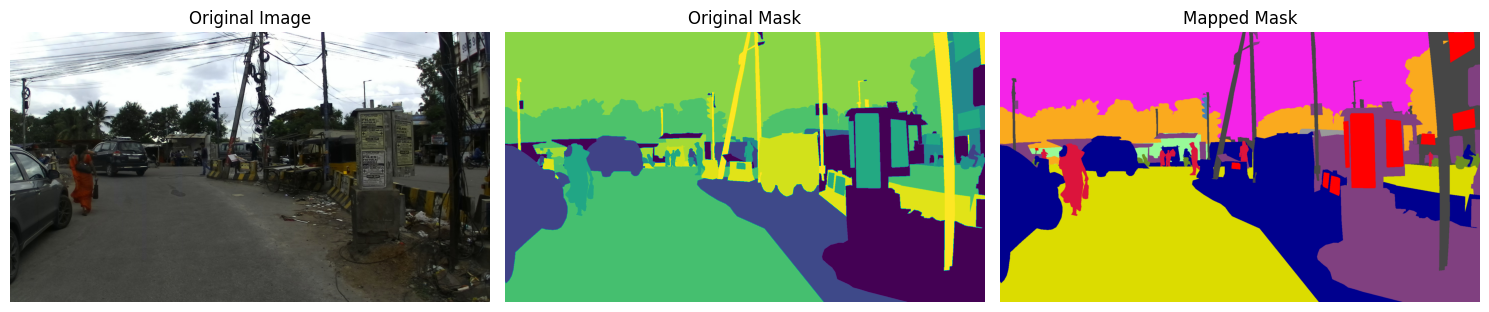


Class Mapping Details:
Original Value -> Mapped Class (Name)
----------------------------------------
Value 0 -> Class 0 (road)
Value 29 -> Class 6 (vehicle)
Value 30 -> Class 6 (vehicle)
Value 33 -> Class 6 (vehicle)
Value 48 -> Class 9 (pole)
Value 70 -> Class 10 (construction)
Value 76 -> Class 11 (vegetation)
Value 89 -> Class 4 (person)
Value 91 -> Class 5 (rider)
Value 106 -> Class 7 (traffic sign)
Value 108 -> Class 8 (traffic light)
Value 124 -> Class 2 (sidewalk)
Value 130 -> Class 3 (non-drivable)
Value 137 -> Class 12 (sky)
Value 140 -> Class 6 (vehicle)
Value 143 -> Class 6 (vehicle)
Value 150 -> Class 10 (construction)


In [12]:
def check_class_mapping(dataset, idx=0):
    # Get image and mask paths
    img_name = dataset.images[idx]
    img_path = os.path.join(dataset.image_dir, img_name)
    mask_name = img_name.replace('_leftImg8bit.png', '_gtFine_polygons.png')
    mask_path = os.path.join(dataset.mask_dir, mask_name)
    
    # Load original files
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    print("Original unique mask values:", sorted(np.unique(mask)))
    
    # Create mapped mask
    mapped_mask = np.zeros_like(mask)
    for raw_label, class_id in IDD_LABEL_MAP.items():
        mapped_mask[mask == raw_label] = class_id
    
    print("Mapped unique values:", sorted(np.unique(mapped_mask)))
    
    # Create colored visualization
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_id, (name, color) in IDD_CLASSES.items():
        colored_mask[mapped_mask == class_id] = color
    
    # Plot
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(mask)
    plt.title("Original Mask")
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(colored_mask)
    plt.title("Mapped Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print mapping details
    print("\nClass Mapping Details:")
    print("Original Value -> Mapped Class (Name)")
    print("-" * 40)
    for orig_val in sorted(np.unique(mask)):
        mapped_val = IDD_LABEL_MAP.get(orig_val)
        if mapped_val is not None:
            class_name = next((name for id, (name, _) in IDD_CLASSES.items() if id == mapped_val), "Unknown")
            print(f"Value {orig_val} -> Class {mapped_val} ({class_name})")
        else:
            print(f"Value {orig_val} -> Not mapped")

    # Print unmapped values
    unmapped = [val for val in np.unique(mask) if val not in IDD_LABEL_MAP]
    if unmapped:
        print("\nWARNING: Found unmapped values:", unmapped)

# Check mapping for first image
check_class_mapping(train_dataset, 0)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=14):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.double_conv(n_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)
        
        # Bridge
        self.bridge = self.double_conv(512, 1024)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(128, 64)
        
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)
        
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        x = self.maxpool(enc1)
        
        enc2 = self.enc2(x)
        x = self.maxpool(enc2)
        
        enc3 = self.enc3(x)
        x = self.maxpool(enc3)
        
        enc4 = self.enc4(x)
        x = self.maxpool(enc4)
        
        # Bridge
        x = self.bridge(x)
        
        # Decoder with skip connections
        x = self.up1(x)
        x = torch.cat([enc4, x], dim=1)
        x = self.dec1(x)
        
        x = self.up2(x)
        x = torch.cat([enc3, x], dim=1)
        x = self.dec2(x)
        
        x = self.up3(x)
        x = torch.cat([enc2, x], dim=1)
        x = self.dec3(x)
        
        x = self.up4(x)
        x = torch.cat([enc1, x], dim=1)
        x = self.dec4(x)
        
        return self.final(x)


In [14]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.mode = mode
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [15]:
def calculate_iou(pred, target, n_classes=14):
    ious = []
    pred = pred.argmax(dim=1)
    for cls in range(n_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        
        intersection = (pred_mask & target_mask).float().sum()
        union = (pred_mask | target_mask).float().sum()
        
        iou = intersection / (union + 1e-6)  # Adding small epsilon to avoid division by zero
        ious.append(iou.item())
    return np.mean(ious)

In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    
    with tqdm(loader, desc="Training") as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.long().to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate IoU
            batch_iou = calculate_iou(outputs.detach(), masks)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_iou += batch_iou
            
            pbar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "IoU": f"{batch_iou:.4f}"
            })
    
    return epoch_loss / len(loader), epoch_iou / len(loader)


In [18]:
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    val_iou = 0
    
    with torch.no_grad():
        with tqdm(loader, desc="Validation") as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.long().to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate IoU
                batch_iou = calculate_iou(outputs, masks)
                
                val_loss += loss.item()
                val_iou += batch_iou
                
                pbar.set_postfix({
                    "Val Loss": f"{loss.item():.4f}",
                    "Val IoU": f"{batch_iou:.4f}"
                })
    
    return val_loss / len(loader), val_iou / len(loader)

In [19]:
# Initialize model, optimizer, and criterion
model = UNet(n_channels=3, n_classes=14).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

# Training Loop
num_epochs = 50
best_val_loss = float('inf')
best_val_iou = 0

# Add gradient clipping to prevent exploding gradients
max_grad_norm = 1.0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou = validate(model, val_loader, criterion, device)
    
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break
    
    # Save best model based on both loss and IoU
    if val_loss < best_val_loss or val_iou > best_val_iou:
        best_val_loss = min(val_loss, best_val_loss)
        best_val_iou = max(val_iou, best_val_iou)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_iou': val_iou,
        }, 'best_model.pth')
        print(f"Saved best model with Val Loss: {val_loss:.4f} and Val IoU: {val_iou:.4f}")


Epoch 1/50


Validation: 100%|██████████| 306/306 [01:01<00:00,  5.00it/s, Val Loss=1.9086, Val IoU=0.1426]


Train Loss: 1.1383, Train IoU: 0.2058
Val Loss: 0.8628, Val IoU: 0.2313
Saved best model with Val Loss: 0.8628 and Val IoU: 0.2313

Epoch 2/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.82it/s, Val Loss=1.8506, Val IoU=0.1589]


Train Loss: 0.8534, Train IoU: 0.2358
Val Loss: 0.7661, Val IoU: 0.2597
Saved best model with Val Loss: 0.7661 and Val IoU: 0.2597

Epoch 3/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.84it/s, Val Loss=1.7986, Val IoU=0.1335]


Train Loss: 0.7747, Train IoU: 0.2612
Val Loss: 0.7278, Val IoU: 0.2788
Saved best model with Val Loss: 0.7278 and Val IoU: 0.2788

Epoch 4/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.79it/s, Val Loss=1.6711, Val IoU=0.1497]


Train Loss: 0.7215, Train IoU: 0.2792
Val Loss: 0.7079, Val IoU: 0.2771
Saved best model with Val Loss: 0.7079 and Val IoU: 0.2771

Epoch 5/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.81it/s, Val Loss=1.6949, Val IoU=0.1779]


Train Loss: 0.6909, Train IoU: 0.2948
Val Loss: 0.7019, Val IoU: 0.2899
Saved best model with Val Loss: 0.7019 and Val IoU: 0.2899

Epoch 6/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.84it/s, Val Loss=1.5501, Val IoU=0.1911]


Train Loss: 0.6551, Train IoU: 0.3122
Val Loss: 0.6675, Val IoU: 0.3057
Saved best model with Val Loss: 0.6675 and Val IoU: 0.3057

Epoch 7/50


Validation: 100%|██████████| 306/306 [00:53<00:00,  5.71it/s, Val Loss=1.7833, Val IoU=0.1750]


Train Loss: 0.6334, Train IoU: 0.3281
Val Loss: 0.6494, Val IoU: 0.3118
Saved best model with Val Loss: 0.6494 and Val IoU: 0.3118

Epoch 8/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.79it/s, Val Loss=2.0411, Val IoU=0.1762]


Train Loss: 0.6053, Train IoU: 0.3403
Val Loss: 0.6309, Val IoU: 0.3281
Saved best model with Val Loss: 0.6309 and Val IoU: 0.3281

Epoch 9/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.84it/s, Val Loss=1.5943, Val IoU=0.2021]


Train Loss: 0.6075, Train IoU: 0.3453
Val Loss: 0.6059, Val IoU: 0.3362
Saved best model with Val Loss: 0.6059 and Val IoU: 0.3362

Epoch 10/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.85it/s, Val Loss=1.5047, Val IoU=0.1940]


Train Loss: 0.5736, Train IoU: 0.3603
Val Loss: 0.6203, Val IoU: 0.3261

Epoch 11/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.80it/s, Val Loss=1.6901, Val IoU=0.1835]


Train Loss: 0.5684, Train IoU: 0.3649
Val Loss: 0.6153, Val IoU: 0.3459
Saved best model with Val Loss: 0.6153 and Val IoU: 0.3459

Epoch 12/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.81it/s, Val Loss=1.9488, Val IoU=0.1661]


Train Loss: 0.5573, Train IoU: 0.3727
Val Loss: 0.5847, Val IoU: 0.3518
Saved best model with Val Loss: 0.5847 and Val IoU: 0.3518

Epoch 13/50


Validation: 100%|██████████| 306/306 [00:53<00:00,  5.75it/s, Val Loss=1.6720, Val IoU=0.1995]


Train Loss: 0.5522, Train IoU: 0.3771
Val Loss: 0.5773, Val IoU: 0.3556
Saved best model with Val Loss: 0.5773 and Val IoU: 0.3556

Epoch 14/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.81it/s, Val Loss=1.8954, Val IoU=0.1945]


Train Loss: 0.5286, Train IoU: 0.3851
Val Loss: 0.5829, Val IoU: 0.3535

Epoch 15/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.85it/s, Val Loss=1.6719, Val IoU=0.1945]


Train Loss: 0.5278, Train IoU: 0.3892
Val Loss: 0.6015, Val IoU: 0.3488

Epoch 16/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.85it/s, Val Loss=1.9964, Val IoU=0.1748]


Train Loss: 0.5207, Train IoU: 0.3929
Val Loss: 0.5629, Val IoU: 0.3680
Saved best model with Val Loss: 0.5629 and Val IoU: 0.3680

Epoch 17/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.88it/s, Val Loss=1.4027, Val IoU=0.2473]


Train Loss: 0.5120, Train IoU: 0.3980
Val Loss: 0.5322, Val IoU: 0.3738
Saved best model with Val Loss: 0.5322 and Val IoU: 0.3738

Epoch 18/50


Validation: 100%|██████████| 306/306 [00:53<00:00,  5.75it/s, Val Loss=1.3843, Val IoU=0.2220]


Train Loss: 0.5120, Train IoU: 0.3994
Val Loss: 0.5403, Val IoU: 0.3678

Epoch 19/50


Validation: 100%|██████████| 306/306 [00:53<00:00,  5.75it/s, Val Loss=1.1444, Val IoU=0.2609]


Train Loss: 0.4934, Train IoU: 0.4049
Val Loss: 0.5263, Val IoU: 0.3802
Saved best model with Val Loss: 0.5263 and Val IoU: 0.3802

Epoch 20/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.78it/s, Val Loss=1.6686, Val IoU=0.1959]


Train Loss: 0.4899, Train IoU: 0.4113
Val Loss: 0.5275, Val IoU: 0.3838
Saved best model with Val Loss: 0.5275 and Val IoU: 0.3838

Epoch 21/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.84it/s, Val Loss=1.4193, Val IoU=0.2239]


Train Loss: 0.4831, Train IoU: 0.4142
Val Loss: 0.5571, Val IoU: 0.3634

Epoch 22/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.85it/s, Val Loss=1.5961, Val IoU=0.2044]


Train Loss: 0.4842, Train IoU: 0.4138
Val Loss: 0.5168, Val IoU: 0.3807
Saved best model with Val Loss: 0.5168 and Val IoU: 0.3807

Epoch 23/50


Validation: 100%|██████████| 306/306 [00:52<00:00,  5.85it/s, Val Loss=1.4272, Val IoU=0.2585]


Train Loss: 0.4734, Train IoU: 0.4226
Val Loss: 0.5088, Val IoU: 0.3877
Saved best model with Val Loss: 0.5088 and Val IoU: 0.3877

Epoch 24/50


Training:  84%|████████▍ | 834/995 [05:57<01:08,  2.34it/s, Loss=0.4662, IoU=0.4941]